In [109]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from matplotlib.animation import FuncAnimation, FFMpegWriter
from functools import partial
from itertools import product
from scipy.optimize import linprog
import cvxpy as cp

# Rotate vector by angle theta
def rotate_mat(theta):
    return np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta),  np.cos(theta)]])

# Reflect point across line with slope m
def reflect_mat(m):
    return (1/(1+m**2))*np.array([[1-m**2, 2*m],
                                  [2*m, m**2-1]])

# Find angles of tangents to curve 
# using forward and backward differences at ends
def get_tans(pts0):
    ltang = math.atan2(pts0[1, 1] - pts0[1, 0], 
                       pts0[0, 1] - pts0[0, 0])
    rtang = math.atan2(pts0[1, -1] - pts0[1, -2], 
                       pts0[0, -1] - pts0[0, -2])
    return np.array([ltang, rtang])
    
# Given matrix M (n × k), finds x = M c such that x > 0 elementwise.
# Returns (success, x, c).
def positive_vector_in_column_space(M, eps=0):
    M = np.asarray(M)
    n, k = M.shape
    
    # coefficients for linear combination of columns
    c = cp.Variable(k)
    
    # resulting x
    x = M @ c
    
    # constraints: strictly positive (>= eps)
    constraints = [
        x >= eps * np.ones(n)
    ]
    
    # objective: any simple objective works; minimize norm(c)
    objective = cp.Minimize(cp.norm(c, 2))
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS)
    
    if prob.status not in ["optimal", "optimal_inaccurate"]:
        return False, None, None
    
    x_val = x.value
    c_val = c.value
    
    return True, x_val, c_val

class Curve:
    def __init__(self, pts0, pts, sign):
        self.pts0 = np.array(pts0)
        self.pts = np.array(pts)
        self.sign = sign
        
        self.ltang0 = get_tans(pts0)[0]
        self.rtang = get_tans(pts)[1]
        self.ends = np.array([self.pts[:, 0], self.pts[:, -1]])

    def transform(self, scale, parity):
        rotate = self.rtang - self.ltang0
        if self.sign < 0:
            rotate = rotate + np.pi
        R = rotate_mat(rotate)
        Flip = reflect_mat(np.tan(self.rtang))
        shift_matrix = np.tile(self.ends[1], (self.pts.shape[1], 1)).T
        if parity == 0:
            return (R @ self.pts0*scale) + shift_matrix
        elif parity == 1:
            return Flip @ (R @ self.pts0*scale) + shift_matrix

class vector:
    def __init__(self, pts0, pts, tans, angle, parity0, sign):
        self.pts0 = pts0
        self.pts = pts
        self.tans = tans
        self.angle = angle
        self.parity0 = parity0
        self.sign = sign
        
    def transform(self, scale, parity):
        sign = np.sign(scale)
        if self.parity0 == 0:
            rotate = self.angle + self.tans[1] - self.tans[0]
        if self.parity0 == 1:
            rotate = 2*self.angle - (self.angle + self.tans[1]) - self.tans[0]
        if self.sign < 0:
            rotate = rotate + np.pi
        R = rotate_mat(rotate)
        Flip = reflect_mat(math.tan(rotate + self.tans[0]))
        if parity == 0:
            return R @ self.pts0*scale
        elif parity == 1:
            return (Flip @ (R @ self.pts0))*scale
            
class solution:
    def __init__(self, start, stop, n_points, g, N):
        self.start = start
        self.stop = stop
        self.n_points = n_points
        self.g = g
        self.N = N
        self.solutions_dict = {}

    def make_points(self, stop):
        t = np.linspace(self.start, stop, self.n_points)
        pts0 = self.g(t) - np.tile(self.g(self.start), (self.g(t).shape[1], 1)).T
        angle0 = math.atan2(pts0[1, -1] - pts0[1, 0], 
                            pts0[0, -1] - pts0[0, 0])
        R = rotate_mat(-angle0)
        pts0 = R @ pts0
        return pts0

    def make_shape(self, pts0, scale_list, parity_list):
        curves = [Curve(pts0, pts0*scale_list[0], np.sign(scale_list[0]))]
        for i in range(len(parity_list)-1):
            prev = curves[-1]
            curves.append(Curve(pts0, prev.transform(scale_list[i+1], parity_list[i+1]), np.sign(scale_list[i+1])))
        return curves

    def make_vectors(self, pt0, tans, scale_list, parity_list):
        vectors = [vector(pt0, pt0*scale_list[0], tans, 0, 0, np.sign(scale_list[0]))]
        for i in range(len(parity_list)-1):
            prev = vectors[-1]
            new_vec = prev.transform(scale_list[i+1], parity_list[i+1])
            angle = math.atan2(new_vec[1], new_vec[0])
            vectors.append(vector(pt0, new_vec, tans, angle, parity_list[i+1], np.sign(scale_list[i+1])))
        return vectors

    def find_solutions(self):
        # Creates all possible parity lists of length N
        # When count(0) = count(1) no solns are possible
        all_parity_lists = [
            list(p) for p in product([0, 1], repeat=N) 
            if p[0] == 0 and p.count(0) != p.count(1)
            ]
        
        # Start with initial curve
        pts0 = self.make_points(self.stop)
    
        # Find t values with gradient which will create
        # a closed loop for the given N and parity list
        gradient = np.gradient(pts0[1])/np.gradient(pts0[0])
        ltang = get_tans(pts0)[0]
        t = np.linspace(self.start, self.stop, self.n_points)
        
        for parity_list in all_parity_lists:
            # Solve for possible derivatives, find those derivatives
            # Between start and stop
            n0 = parity_list.count(0)
            n1 = parity_list.count(1)
            derivs = []
            n = [-1, 0, 1]
            for i in n:
                derivs.append(math.tan((2*np.pi*i)/(n0-n1) + ltang))
            stops = []
            for i, grad in enumerate(gradient):
                for j, solut in enumerate(derivs): 
                    if np.isclose(grad, solut, atol=0.01) and i!= 0:
                        stops.append(t[i])
                    if i != 0 and len(stops) > 1:
                        if np.isclose(t[i], stops[-2], atol = 0.001):
                            stops.remove(t[i])
                    
            for stop in stops:
                # Make new points based on stop
                pts1 = self.make_points(stop) 
                pt1 = pts1[:, -1]
                tans1 = get_tans(pts1)
                
                # Create initial vectors with parity list
                vectors1 = self.make_vectors(pt1, tans1, [1] * N, parity_list)
                vectors1_mat = np.column_stack([vector1.pts for vector1 in vectors1])
        
                # Find null space of initial vectors
                # AKA vector space of scales which will close the loop
                null_space = scipy.linalg.null_space(vectors1_mat)
                sign = "mixed"
                self.solutions_dict[(tuple(parity_list), stop, sign)] = (pts1, null_space)
        print(len(self.solutions_dict))
        
    def graph_all_solutions(self):
        # Find the maximum number of null vectors for layout
        max_null_vectors = max(
            null_space.shape[1] 
            for sol in self.solutions_dict.values() 
            if sol is not None
            for null_space in [sol[1]]
        )
    
        num_solutions = len(self.solutions_dict)
        
        # Determine subplot grid size (rows = num solutions, columns = max null vectors)
        fig, axes = plt.subplots(num_solutions, max_null_vectors, figsize=(4*max_null_vectors, 4*num_solutions), squeeze=False)

        #Give each (parity_list, stop) solution a row
        for i, ((parity_list, stop, sign), sol) in enumerate(self.solutions_dict.items()):
            if sol is None:
                # Skip empty solutions
                for j in range(max_null_vectors):
                    axes[i, j].axis('off')
                continue
            
            pts, null_space = sol
            null_vectors = null_space.T 

            # Give each null vector in the solution a column
            for j in range(max_null_vectors):
                ax = axes[i, j]
                if j < null_vectors.shape[0]:
                    scales = null_vectors[j]
                    curves = self.make_shape(pts, scales, parity_list)
                    graph_pts = np.concatenate([c.pts for c in curves], axis=1)
                    ax.plot(graph_pts[0, :], graph_pts[1, :])
                    ax.set_title(f"Parity: {parity_list}\nStop: {stop:.2f}\nNull vec: {j}\nSign: {sign}")
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()

    # Finds solutions_dict item close to stop_target requested
    def index_helper(self, parity_list, stop_target, sign, tol=0.01):
        key_candidates = [key for key in self.solutions_dict.keys() 
                          if key[0] == tuple(parity_list) 
                          and abs(key[1] - stop_target) < tol
                          and key[2] == sign]

        if not key_candidates:
            print(f"No solution found for parity {parity_list} near stop {stop_target}")
            return

        # Pick the closest stop
        closest_key = min(key_candidates, key=lambda k: abs(k[1] - stop_target))
        return self.solutions_dict[closest_key]
    
    def compute_extremum(self, parity_list, stop_target, sign):
        global_xmin = +np.inf
        global_xmax = -np.inf
        global_ymin = +np.inf
        global_ymax = -np.inf

        pts, null_space = self.index_helper(parity_list, stop_target, sign)
        N = null_space.shape[1]
        
        for i in range(N):
            scales = null_space[:, i]
        
            curves = self.make_shape(pts, scales, parity_list)
            frame_pts = np.concatenate([obj.pts for obj in curves], axis=1)
        
            global_xmin = min(global_xmin, frame_pts[0].min())
            global_xmax = max(global_xmax, frame_pts[0].max())
            global_ymin = min(global_ymin, frame_pts[1].min())
            global_ymax = max(global_ymax, frame_pts[1].max())
            
        return [global_xmin, global_xmax, global_ymin, global_ymax]


    def update(self, frame_idx, pts, null_space, parity_list, xmin, xmax, ymin, ymax, mode, random_list, num_nodes, frame_num):
        if mode == "linear":
            N = null_space.shape[1]
            segment = frame_idx // frame_num
            t = (frame_idx % frame_num) / frame_num
        
            # indices of start and end null vectors for interpolation
            i0 = segment % N
            i1 = (segment + 1) % N
        
            # linear interpolation coefficients
            a = 1 - t
            b = t
            scales = null_space[:, i0] * a + null_space[:, i1] * b

        if mode=="random":     
            segment = frame_idx // frame_num
            t = (frame_idx % frame_num) / frame_num
        
            # indices of start and end null vectors for interpolation
            i0 = segment % num_nodes
            i1 = (segment + 1) % num_nodes
            a = 1 - t
            b = t

            null_coeffs = random_list[i0]*a + random_list[i1]*b
            scales = null_space @ null_coeffs.T
        
        curves = self.make_shape(pts, scales, parity_list)
        frame_pts = np.concatenate([obj.pts for obj in curves], axis=1)
        
        self.ax.clear()
        self.ax.plot(frame_pts[0, :], frame_pts[1, :])
        self.ax.set_xlim(xmin, xmax)
        self.ax.set_ylim(ymin, ymax)
        self.ax.axis('off')

    def animate_solution(self, parity_list, stop_target, sign, mode, file_name, num_nodes = 3, alpha = 1, frame_num = 200):
        self.fig, self.ax = plt.subplots()
        extremum = self.compute_extremum(parity_list, stop_target, sign)

        pts, null_space = self.index_helper(parity_list, stop_target, sign)
        
        if mode=="linear":
            
            trajectory =[0]
            frames = frame_num*null_space.shape[1]

            dirichlet_list = None
    
        if mode=="random":
            
            n = null_space.shape[1]
            alpha0 = np.ones(n)*alpha
            dirichlet_list = np.random.dirichlet(alpha0, size=num_nodes) 
            frames = frame_num*num_nodes
            
        ani = FuncAnimation(
            self.fig, 
            partial(
                self.update, 
                pts=pts, 
                null_space=null_space,
                parity_list = parity_list,
                xmin = extremum[0]-0.5,
                xmax = extremum[1]+0.5,
                ymin = extremum[2]-0.5,
                ymax = extremum[3]+0.5,
                mode = mode, 
                random_list = dirichlet_list,
                num_nodes = num_nodes,
                frame_num = frame_num), 
            frames=frames,
            interval=200)
        ani.save(f"{file_name}.mp4", writer="ffmpeg", fps=60)

    # Finds basis for the null_space where each basis vector has no negative elements and one element is 0
    # Setting one element to be 0 just gives a natural "basis" for the positive cone
    # Even though this isn't a vector space
    def transform_null_space(self, parity_list, stop_target):
        pts, M = self.index_helper(parity_list, stop_target, sign="mixed")
        n, k = M.shape
    
        positive_vectors = []
        eps = 1e-6
        
        for j in range(n):
            row = M[j, :].reshape(1, -1)
            C_j = scipy.linalg.null_space(row)
            
            if C_j.size == 0:
                continue
            
            X_j = M @ C_j    # n × d
            p, d = X_j.shape
            
            eps = 0
            prob, x, c = positive_vector_in_column_space(X_j, eps=eps)
            x_norm = x / np.linalg.norm(x)
            if any(x_norm < -0.001):
                continue
            x_norm[j]=1e-12
            positive_vectors.append(x_norm)
    
        if positive_vectors:
            stacked = np.column_stack(positive_vectors)
            self.solutions_dict[(tuple(parity_list), stop_target, "positive")] = (pts, stacked)
            print(f"Found {len(positive_vectors)} strictly positive null vectors.")
        else:
            print("No positive vectors found.")
    



23
Found 5 strictly positive null vectors.


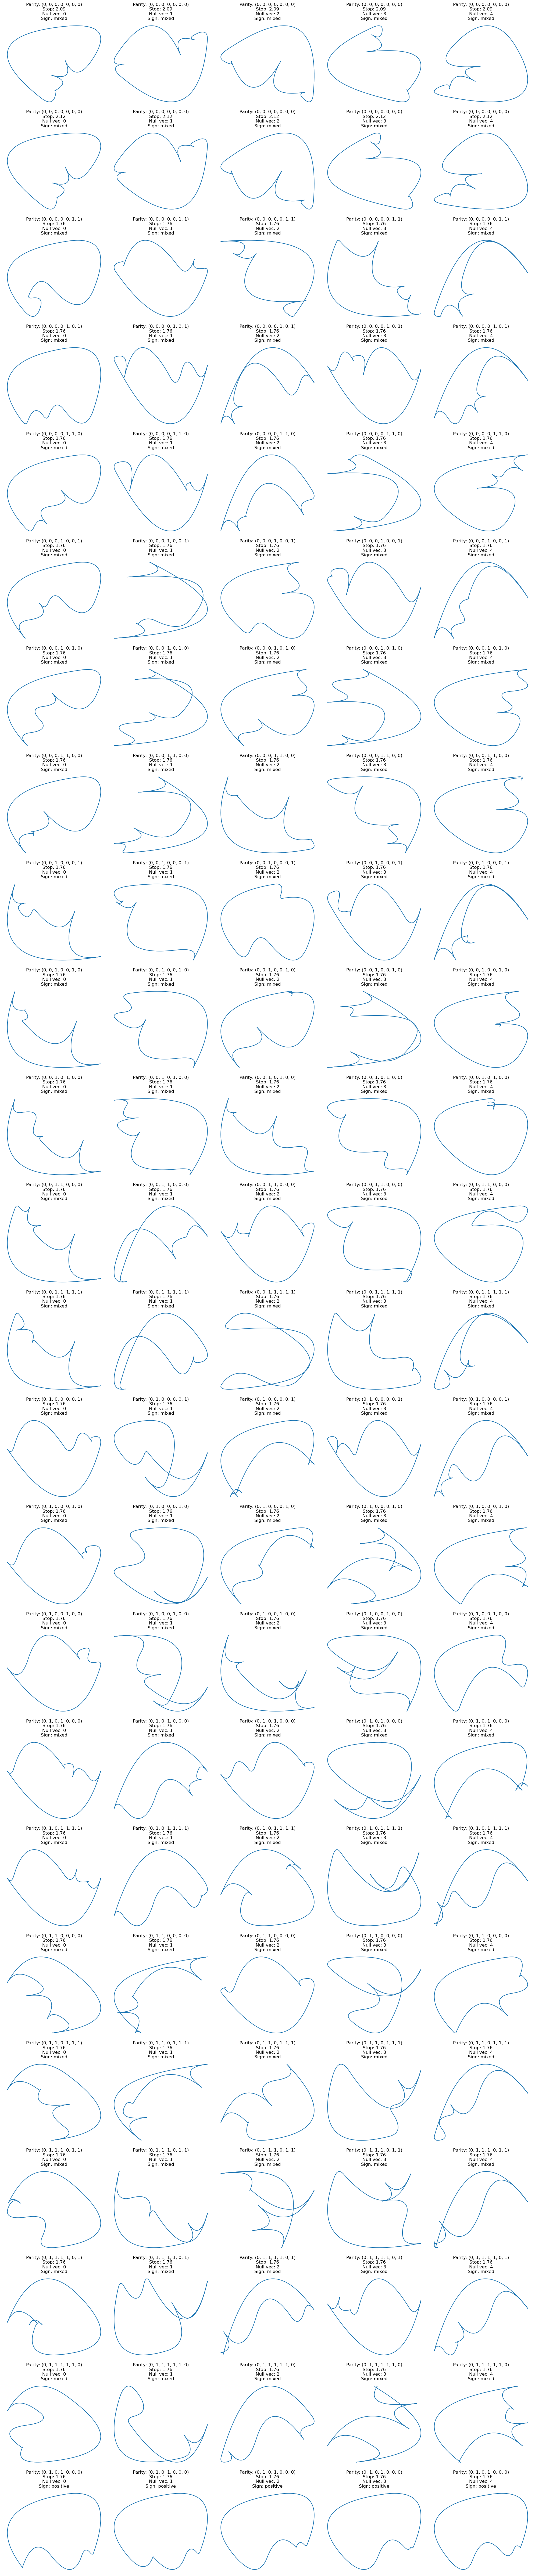

In [113]:
# Edit these params to create new graphs

start = 0
stop = 3
num_points = 100
N = 7

def g(t):
    return np.array([t, (t-1)**2-1])

# solution(start,stop,num_points, g, N) creates solution object
# based on these params and self.find_solutions() finds orthonormal basis
# for the scales of the closed shapes AKA null space of initial vectors with uniform scaling
# for all possible parity lists for all stops in the search area (start, stop)

solution1 = solution(start, stop, num_points, g, N)
solution1.find_solutions()

# self.transform_null_space(parity_list, stop) makes a basis for the scales of the closed shapes
# which is nonnegative elementwise (ie x[i] >= 0) and 0 in atleast 1 element
# for solution with solution_dict index (parity_list, stop, sign = "mixed")
# This prevents any negative scales, which add sharp "kinks" to the shape
# Scales of value 0 also produce kinks, but in general a linear combination of this basis will be smooth
# The produced solution will be added to solution_dict with index (parity_list, stop, sign = "positive")

solution1.transform_null_space([0, 0, 0, 1, 0, 1, 0], 1.76)

#graph_all_solutions() makes a subplot for each column in the null_space (columns in the figure)
# of each (parity_list, stop, sign) solution in self.solutions_dict (rows in the figure)

solution1.graph_all_solutions()

In [ ]:
# self.animate_solution(parity_list, stop, sign, mode, file_name, num_nodes=num_nodes, alpha=alpha, frame_num=frame_num)
# creates a video for solution with self.solution_dict index (parity_list, stop, sign)
# The video mode can either be "linear" which moves smoothly from one null vector to the next through the whole null space
# or "random" which finds a num_nodes length set of coefficients for the null vectors with dirichlet sampling of spread alpha
# and interpolates between these nodes. 
# The file is saved as file_name.mp4
# frame_num is the number of frames between null vectors for linear, and the number of frames between nodes for random
# num_nodes and alpha are only used for mode = "random"

solution1.animate_solution([0, 0, 0, 1, 0, 1, 0], 1.76, "positive", "linear", "faces", frame_num = 50)